In [1]:
# from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd 
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from openTSNE import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import scipy.stats as stats


In [3]:
allcells = pd.read_csv('../analysis/step1/all_cells_dataset_python_filtered_spikes.csv',index_col=0)

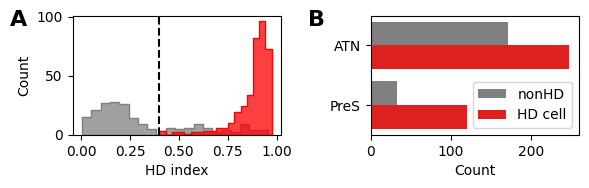

In [545]:
fig, axes= plt.subplots(ncols=2,nrows=1,figsize=(6,2))
custom_cmap_hd = ['grey', 'red']
sns.histplot(allcells.loc[allcells.ishdcell==0].hd_index,color='grey',element='step',bins=20,ax=axes[0])
sns.histplot(allcells.loc[allcells.ishdcell==1].hd_index,color='red',element='step',bins=18,ax=axes[0])

axes[0].axvline(x=.4,color='black',linestyle='--')
axes[0].set_xlabel('HD index')
g=sns.countplot(data=allcells,y='region',hue='ishdcell',ax=axes[1],palette=custom_cmap_hd)
legend = g.legend(title='')
for i,l in enumerate(['nonHD','HD cell']):
    legend.texts[i].set_text(l)
axes[1].set_yticks([0,1],['ATN','PreS'])
axes[1].set_ylabel('')
axes[1].set_xlabel('Count')

for i, ax in enumerate(axes):
    ax.text(-.3, 1.05, chr(65 + i), transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')
plt.tight_layout()

plt.savefig('./plots/cutof_hdindex.pdf',format='pdf')

In [502]:
hdcell_index = np.where((allcells.p_hd_index<.05)&(allcells.hd_index>.4),1,0)
allcells.ishdcell=hdcell_index

In [503]:
label = np.where(allcells.region=='Thalamus',2,4)
label = np.where(allcells.ishdcell==0,0,label)
allcells.loc[:,'true_label']=label


In [4]:
feature_li_all = ['burst_index','var_coef','avg_fr','acg_0','acg_1','acg_2','acg_3','acg_4','wave_0','wave_1','wave_2']


In [ ]:
plt.figure(figsize=(8,8))
sns.pairplot(data=allcells, hue='region', vars=feature_li_all,palette=['green', 'purple'])
plt.savefig('plots/tsne1_features.pdf',format='pdf')

<Figure size 800x800 with 0 Axes>

In [505]:
scaler = StandardScaler()
scaler.fit(allcells[feature_li_all])
x = scaler.transform(allcells[feature_li_all])
perplexity=12

tsne = TSNE(
    perplexity=perplexity,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=False,
)
embedding = tsne.fit(x) 
allcells.loc[:,['tsne_x','tsne_y']]=np.array(embedding)


In [506]:

custom_cmap = ['grey', 'green', 'purple']
custom_palette ={'NonHD cluster':'#E63946',"ATN cluster1": "#2A9D8F", "PreS cluster":"#264653","ATN cluster2": "#F4A261", "Unclustered": "#F4E76E"}



In [508]:
import hdbscan
clusterer = hdbscan.HDBSCAN(algorithm='best',alpha=1.5, leaf_size=12,
    metric='euclidean', min_cluster_size=15,  min_samples=8, p=None)
clusterer.fit(embedding)
allcells.loc[:,'hdscan_label'] = clusterer.labels_
allcells.hdscan_label = allcells.hdscan_label.astype('str')
allcells.loc[allcells.hdscan_label=='3','hdscan_label']='NonHD cluster'
allcells.loc[allcells.hdscan_label=='2','hdscan_label']='PreS cluster'
allcells.loc[allcells.hdscan_label=='0','hdscan_label']='ATN cluster1'
allcells.loc[allcells.hdscan_label=='1','hdscan_label']='ATN cluster2'
allcells.loc[allcells.hdscan_label=='-1','hdscan_label']='Unclustered'



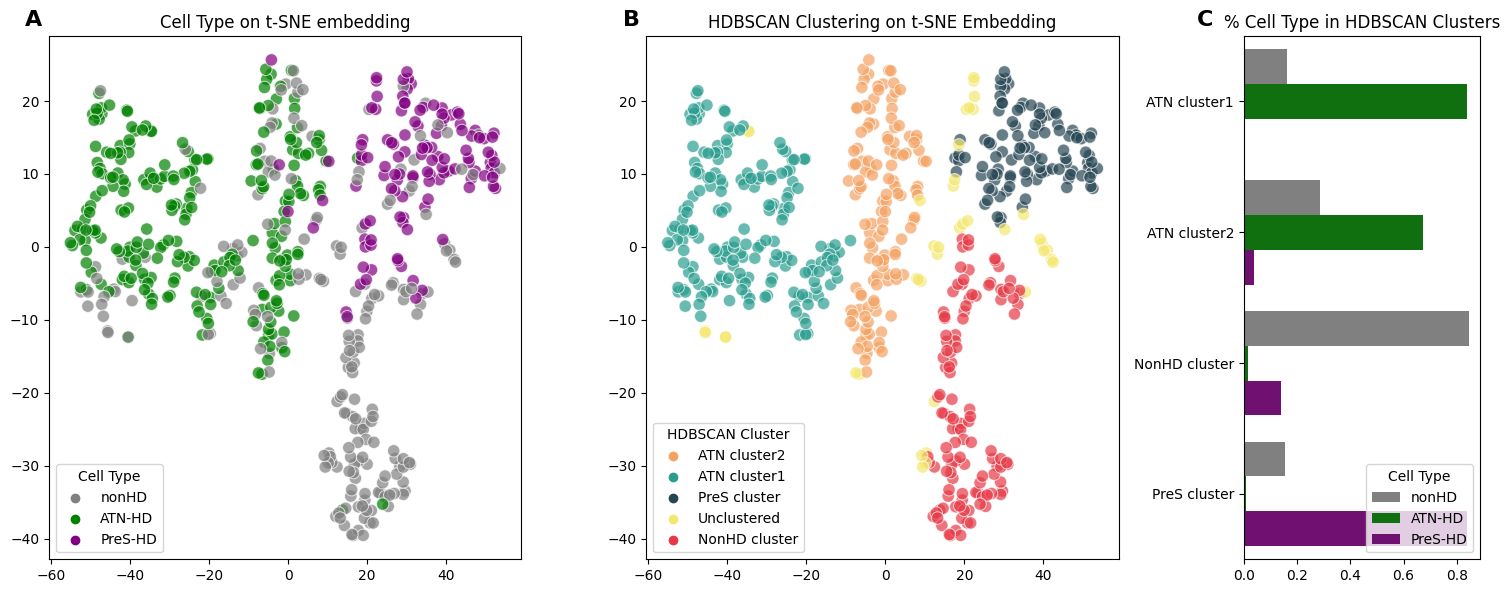

In [509]:
# from sklearn.cluster import KMeans

# kmeans = KMeans(random_state=0, n_init="auto").fit(embedding)
# sns.scatterplot(x=np.array(embedding)[:,0], y=np.array(embedding)[:,1],hue=kmeans.labels_,s=80,alpha=.7,palette='tab10')


fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,6),gridspec_kw={'width_ratios':[2,2,1]})
g = sns.scatterplot(ax=axes[0], data=allcells,x='tsne_x', y='tsne_y',hue='true_label',s=80,alpha=.7,palette=custom_cmap)
axes[0].set_title('Cell Type on t-SNE embedding')
new_labels = ['nonHD', 'ATN-HD','PreS-HD']
legend = g.legend(title='Cell Type')
for i,l in enumerate(new_labels):
    legend.texts[i].set_text(l)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
g=sns.scatterplot(ax=axes[1], data=allcells,x='tsne_x', y='tsne_y',hue='hdscan_label',s=80,alpha=.7,palette=palette)
axes[1].set_title('HDBSCAN Clustering on t-SNE Embedding')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
g.legend(title='HDBSCAN Cluster')

    
counts = allcells.loc[allcells.hdscan_label!='Unclustered'].groupby(['hdscan_label', 'true_label']).size().reset_index(name='counts')
totals = allcells.groupby('hdscan_label').size().reset_index(name='hdscan_label_total')
merged = pd.merge(counts, totals, on='hdscan_label')

# Calculate proportions
merged['proportion'] = merged['counts'] / merged['hdscan_label_total']
merged[['hdscan_label','true_label']] = merged[['hdscan_label','true_label']].astype('str')
g=sns.barplot(ax=axes[2],data=merged,x='proportion',y='hdscan_label',hue="true_label",palette=custom_cmap)
# g.set_yticks(np.arange(0,4),['Cluster 1','Cluster 2','Cluster 3','Cluster 4'])
axes[2].set_ylabel('')
axes[2].set_xlabel('')

new_labels = ['nonHD', 'ATN-HD','PreS-HD']
legend = g.legend(title='Cell Type')
for i,l in enumerate(new_labels):
    legend.texts[i].set_text(l)

axes[2].set_title('% Cell Type in HDBSCAN Clusters')
for i, ax in enumerate(axes[:2]):
    ax.text(-.05, 1.05, chr(65 + i), transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')
axes[2].text(-.2, 1.05, chr(65 + 2), transform=axes[2].transAxes,
        fontsize=16, fontweight='bold', va='top')
plt.tight_layout()
    
plt.savefig('./plots/figure-result1.pdf',format='pdf')

In [510]:
import statannotations
from statannotations.Annotator import Annotator



p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ATN cluster2 vs. ATN cluster1: Welch's t-test independent samples, P_val:7.834e-47 t=-1.885e+01
ATN cluster1 vs. PreS cluster: Welch's t-test independent samples, P_val:6.207e-04 t=-3.473e+00
PreS cluster vs. NonHD cluster: Welch's t-test independent samples, P_val:1.173e-30 t=1.487e+01
ATN cluster2 vs. PreS cluster: Welch's t-test independent samples, P_val:2.373e-36 t=-1.885e+01
ATN cluster1 vs. NonHD cluster: Welch's t-test independent samples, P_val:3.280e-32 t=1.349e+01
ATN cluster2 vs. NonHD cluster: Welch's t-test independent samples, P_val:2.486e-09 t=-6.321e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ATN cluster2 vs. ATN cluster1: Welch's t-test independent sam

ATN cluster2 vs. NonHD cluster: Welch's t-test independent samples, P_val:4.150e-01 t=8.165e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ATN cluster2 vs. ATN cluster1: Welch's t-test independent samples, P_val:2.356e-01 t=1.189e+00
ATN cluster1 vs. PreS cluster: Welch's t-test independent samples, P_val:4.640e-10 t=-6.576e+00
PreS cluster vs. NonHD cluster: Welch's t-test independent samples, P_val:3.597e-30 t=1.337e+01
ATN cluster2 vs. PreS cluster: Welch's t-test independent samples, P_val:3.574e-06 t=-4.755e+00
ATN cluster1 vs. NonHD cluster: Welch's t-test independent samples, P_val:1.348e-17 t=9.401e+00
ATN cluster2 vs. NonHD cluster: Welch's t-test independent samples, P_val:1.655e-17 t=9.238e+00


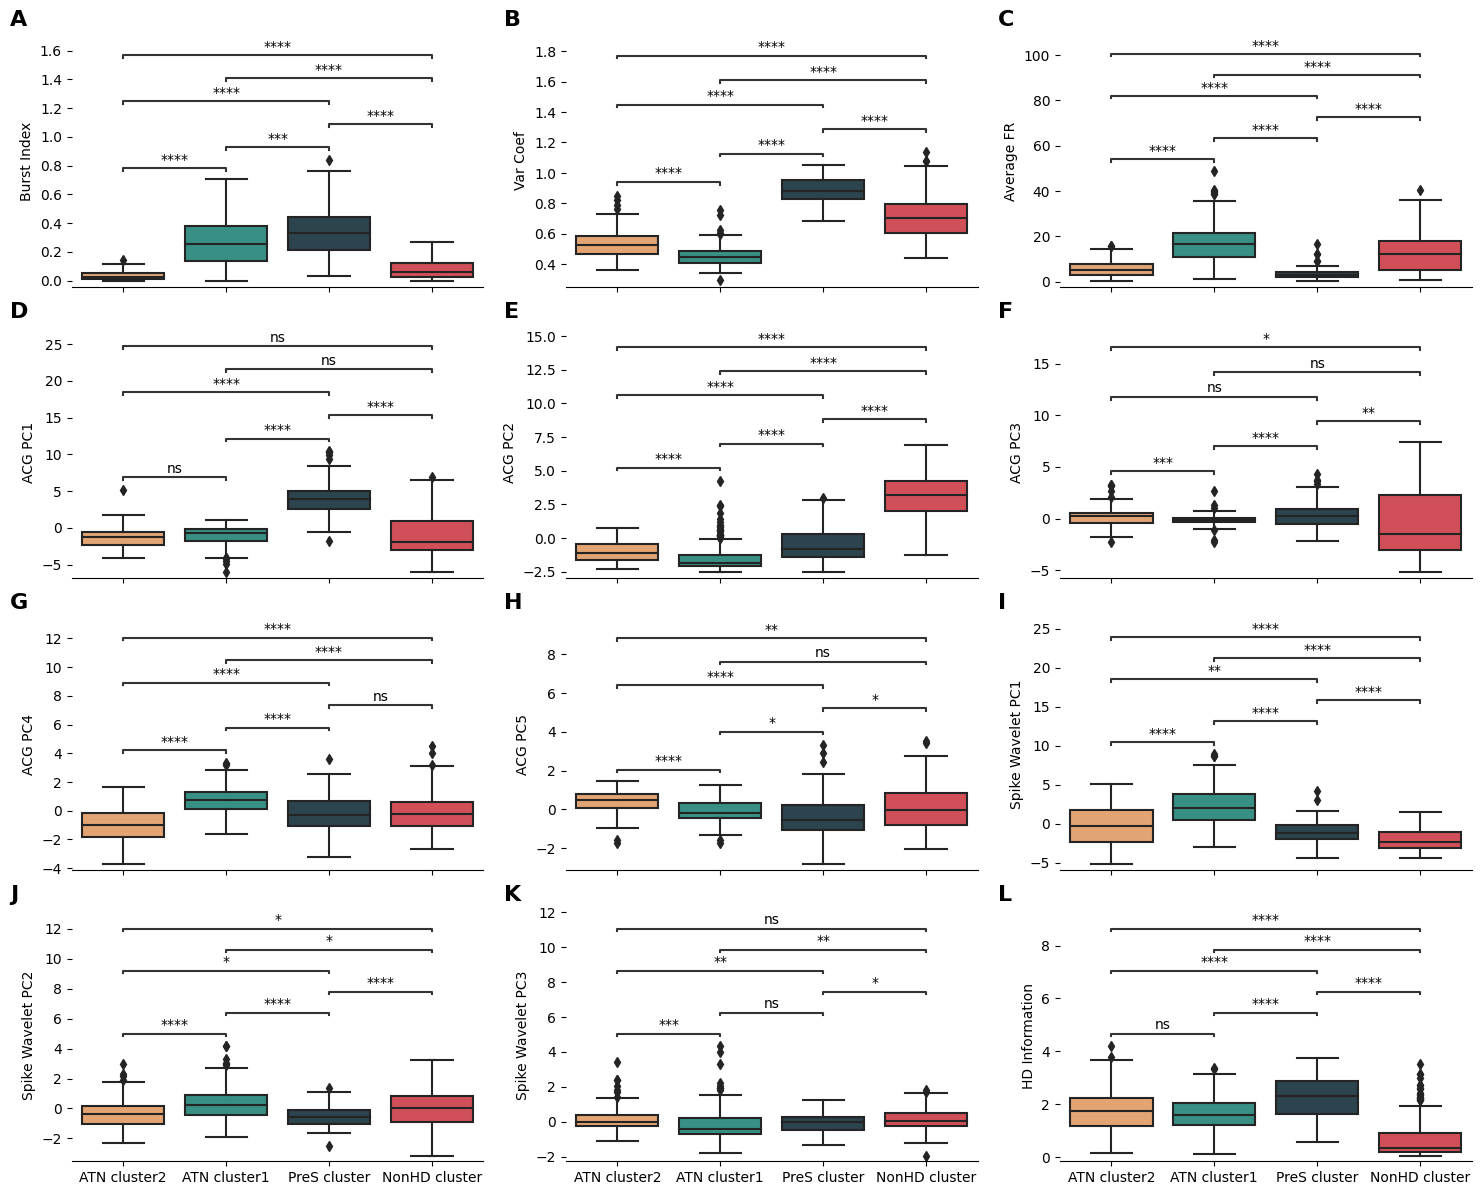

In [511]:
plot_feature_li_all= ['burst_index','var_coef','avg_fr','acg_0','acg_1','acg_2','acg_3','acg_4','wave_0','wave_1','wave_2','hd_info']
plot_feature_name_all = ['Burst Index','Var Coef','Average FR','ACG PC1','ACG PC2','ACG PC3','ACG PC4','ACG PC5',
                         'Spike Wavelet PC1','Spike Wavelet PC2','Spike Wavelet PC3','HD Information']
fig,axes = plt.subplots(ncols=3,nrows=4,figsize=(15,12),sharex=True)
for r in range(4):
    for c in range(3):
        f_id = r*3+c
        sns.boxplot(ax=axes[r,c],data=allcells.loc[allcells.hdscan_label!="Unclustered"],
               x='hdscan_label',y=plot_feature_li_all[f_id],palette=palette)
        axes[r,c].spines['top'].set_visible(False)
        axes[r,c].spines['right'].set_visible(False)
        axes[r,c].spines['left'].set_visible(False)
        axes[r,c].set_xlabel('')
        axes[r,c].set_ylabel(plot_feature_name_all[f_id])
        pairs=[("ATN cluster1", "ATN cluster2"), ("ATN cluster1", "PreS cluster"), ("ATN cluster2", "PreS cluster"), ("ATN cluster1", "NonHD cluster"), ("NonHD cluster", "PreS cluster"), ("ATN cluster2", "NonHD cluster")]

        annotator = Annotator(axes[r,c], pairs, data=allcells.loc[allcells.hdscan_label!="Unclustered"], x='hdscan_label', y=plot_feature_li_all[f_id])
        annotator.configure(test='t-test_welch', text_format='star', loc='inside')
        annotator.apply_and_annotate()
for i, ax in enumerate(axes.flatten()):
    ax.text(-.15, 1.1, chr(65 + i), transform=ax.transAxes,
        fontsize=16, fontweight='bold', va='top')   

plt.tight_layout()
plt.savefig('./result1-1.svg',format='svg')

In [512]:

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(allcells[["tsne_x"]])

# Create and fit the model
regr = LinearRegression()
regr.fit(X_poly, allcells["burst_index"])

# Make predictions
y_pred_burst_index = regr.predict(X_poly)

# Calculate R^2
r2_burst_index = r2_score(allcells["burst_index"], y_pred_burst_index)

temp_df = allcells[['tsne_x','tsne_y','hd_info','acg_1']].dropna()

regr = LinearRegression()
regr.fit(temp_df[["tsne_y",'tsne_x']], temp_df["hd_info"])

# Make predictions
y_pred_hd_info = regr.predict(temp_df[["tsne_y",'tsne_x']])

# Calculate R^2
r2_hd_info = r2_score(temp_df["hd_info"], y_pred_hd_info)

regr.fit(temp_df[["tsne_y",'tsne_x']], temp_df["acg_1"])

# Make predictions
y_pred_acg_1 = regr.predict(temp_df[["tsne_y",'tsne_x']])

# Calculate R^2
r2_acg_1 = r2_score(temp_df["acg_1"], y_pred_acg_1)

# r_hd_info,p_hd_info = stats.spearmanr(temp_df.tsne_y.values,temp_df.hd_info.values)
# r_acg2,p_acg2 = stats.spearmanr(temp_df.acg_1.values,temp_df.tsne_y.values)

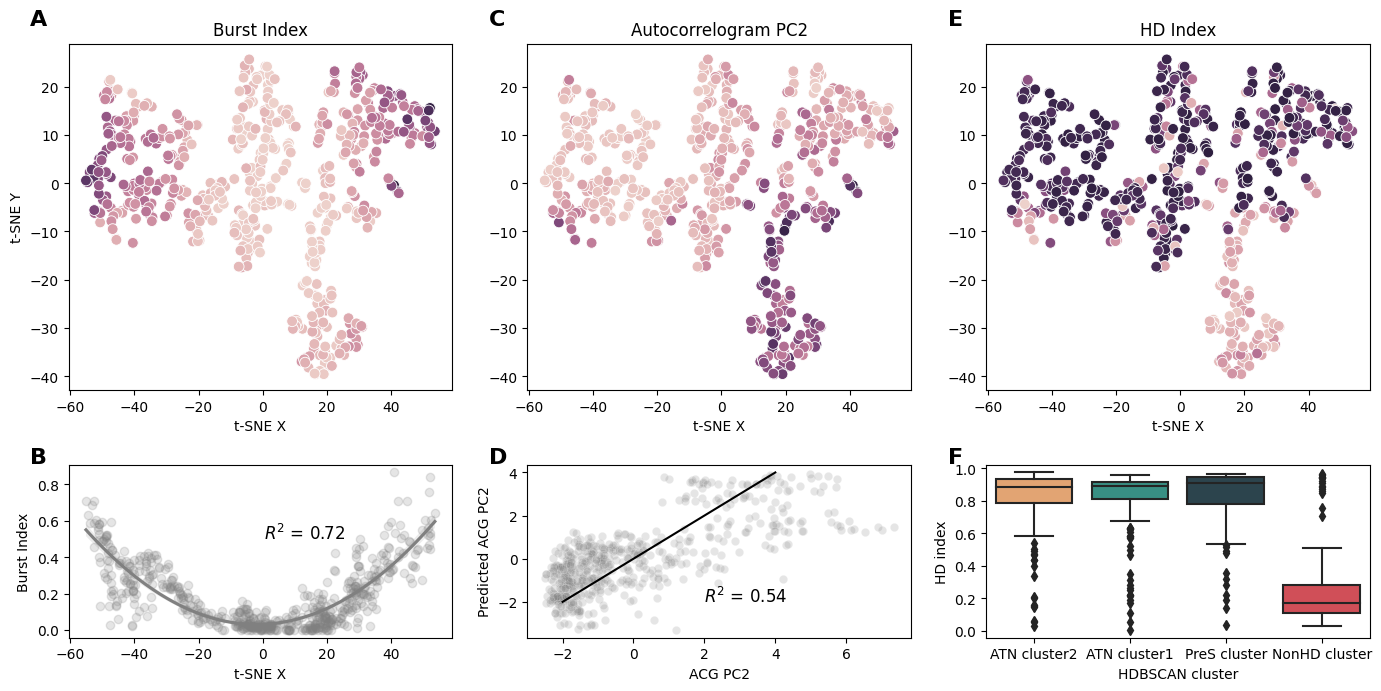

In [546]:
fig,axes=plt.subplots(ncols=3,nrows=2,figsize=(14,7),gridspec_kw={'height_ratios':[4,2]})
sns.scatterplot(data= allcells, x='tsne_x', y='tsne_y',hue='acg_1',ax=axes[0,1],s=60,legend=False)
axes[0,1].set_title('Autocorrelogram PC2')
axes[0,0].set_ylabel('t-SNE Y')
axes[0,1].set_xlabel('t-SNE X')
sns.scatterplot(data= allcells, x='tsne_x', y='tsne_y',hue='burst_index',ax=axes[0,0],s=60,legend=False)
axes[0,0].set_title('Burst Index')
axes[0,1].set_ylabel('')
axes[0,0].set_xlabel('t-SNE X')
sns.scatterplot(data= allcells, x='tsne_x', y='tsne_y',hue='hd_index',ax=axes[0,2],s=60,legend=False)
axes[0,2].set_title('HD Index')
axes[0,2].set_xlabel('t-SNE X')
axes[0,2].set_ylabel('')
sns.scatterplot(x=temp_df['acg_1'].values, y=y_pred_acg_1,color='grey',alpha=.2,ax=axes[1,1])
sns.lineplot(ax=axes[1,1],x=np.linspace(-2,4,100),y=np.linspace(-2,4,100),color='black')

axes[1,1].text(2,-2,f'$R^2$ = {r2_acg_1:.2f}', fontsize=12)
axes[1,1].set_xlabel('ACG PC2')
axes[1,1].set_ylabel('Predicted ACG PC2')
sns.regplot(data= allcells, x='tsne_x', y='burst_index',order=2,color='grey',scatter_kws={'alpha':0.2},ax=axes[1,0])
axes[1,0].text(.5,.5,f'$R^2$ = {r2_burst_index:.2f}', fontsize=12)
axes[1,0].set_ylabel('Burst Index')
axes[1,0].set_xlabel('t-SNE X')
# sns.scatterplot(data=allcells,x='tsne_y',y='hd_index',color='grey',alpha=.2,ax=axes[1,2])
sns.boxplot(data = allcells[allcells.hdscan_label!='Unclustered'],x='hdscan_label', y='hd_index',ax=axes[1,2],palette=palette)
# sns.lineplot(ax=axes[1,2],x=np.linspace(0,3,100),y=np.linspace(0,3,100),color='black')

# axes[1,2].text(2,.8,f'$R^2$ = {r2_hd_info:.2f}', fontsize=12)
axes[1,2].set_ylabel('HD index')
#axes[1,2].set_xlabel('t-SNE Y')
axes[1,2].set_xlabel('HDBSCAN cluster')

for i, ax in enumerate(axes.swapaxes(0,1).flatten()):
    ax.text(-.1, 1.1, chr(65 + i), transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')
plt.tight_layout()
plt.savefig('./plots/figure-result-interpret.pdf',format='pdf')

In [514]:
def find_nearest_point_numpy(points_array, x0, y0):
    distances = np.sqrt(np.sum((points_array - [x0, y0])**2, axis=1))
    min_index = np.argmin(distances)
    return min_index

In [515]:

scaler = StandardScaler()
scaler.fit(allcells.loc[allcells.hdscan_label!='Unclustered'][feature_li_all])
indices = allcells.loc[allcells.hdscan_label!='Unclustered'].index
x = scaler.transform(allcells.loc[allcells.hdscan_label!='Unclustered'][feature_li_all])
y = allcells.loc[allcells.hdscan_label!='Unclustered'].hdscan_label
label = allcells.loc[allcells.hdscan_label!='Unclustered'].true_label
N_repeat = 100
perplexity=12
accall = np.zeros(N_repeat)
predict_label = np.zeros((N_repeat,int(np.ceil(len(x)/10)))).astype('str')
y_label = np.zeros((N_repeat,int(np.ceil(len(x)/10)))).astype('str')

for k in range(N_repeat):
    x_train, x_test, y_train, y_test, train_indice, test_indice = train_test_split(x, y, indices, test_size=.1)
    
    tsne = TSNE(
        perplexity=perplexity,
        metric="euclidean",
        n_jobs=8,
        random_state=42,
        verbose=False,
    )
    embedding_train = tsne.fit(x_train) 
    embedding_test = embedding_train.transform(x_test)

    
    for i in range(len(np.array(embedding_test))):
        min_index = find_nearest_point_numpy(np.array(embedding_train), np.array(embedding_test)[i,0], np.array(embedding_test)[i,0])
        predict_label[k,i]=y_train.values[min_index]
        if (y_train.values[min_index]==y_test.values[i]):
            accall[k] = accall[k]+1
    # print(acc/len(np.array(embedding_test)))
    y_label[k,:] = y_test.values
    accall[k]=accall[k]/len(np.array(embedding_test))
#     print('=========%03d========='%k)

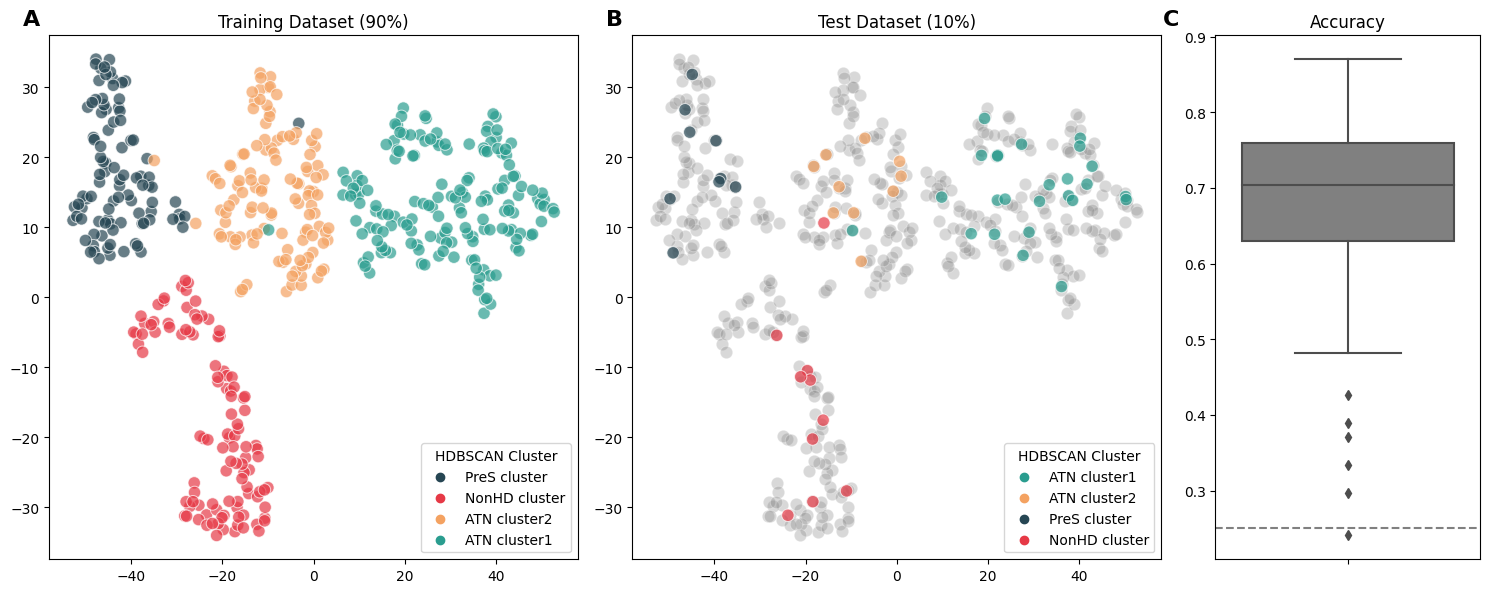

In [516]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,6),gridspec_kw={'width_ratios':[2,2,1]})

g=sns.scatterplot(ax=axes[0],x=np.array(embedding_train)[:,0], y=np.array(embedding_train)[:,1],hue=y_train,s=80,alpha=.7,palette=custom_palette)
axes[0].set_title('Training Dataset (90%)')
g.legend(title='HDBSCAN Cluster')

# new_labels = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4']
# legend = g.legend(title='HDSCAN Cluster')
# for i,l in enumerate(new_labels):
#     legend.texts[i].set_text(l)

sns.scatterplot(ax=axes[1],x=np.array(embedding_train)[:,0], y=np.array(embedding_train)[:,1],s=80,alpha=.3,c='gray')
g=sns.scatterplot(ax=axes[1],x=np.array(embedding_test)[:,0], y=np.array(embedding_test)[:,1],hue=y_test,s=80,alpha=.7,palette=custom_palette)

axes[1].set_title('Test Dataset (10%)')

g.legend(title='HDBSCAN Cluster')
# for i,l in enumerate(new_labels):
#     legend.texts[i].set_text(l)

sns.boxplot(ax=axes[2],y=accall,color='grey',saturation=.5)
axes[2].axhline(y=.25,color='grey',linestyle='--')
axes[2].set_title('Accuracy')
plt.tight_layout()
for i, ax in enumerate(axes[:2]):
    ax.text(-.05, 1.05, chr(65 + i), transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')
axes[2].text(-.2, 1.05, chr(65 + 2), transform=axes[2].transAxes,
        fontsize=16, fontweight='bold', va='top')
plt.savefig('./plots/figure-result1validation.pdf',format='pdf')


Text(0.5, 0, 'FR_diff |$FR_{cw}-FR_{ccw}$|')

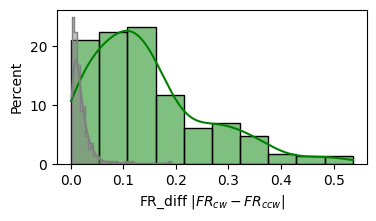

In [568]:
plt.figure(figsize=(4,2))
sns.histplot(data=hdcells.loc[hdcells.region=='Thalamus'],x='maxFR_diff_abs',stat='percent',kde='density',bins=10 ,color='green')

sns.histplot(data=hdcells.loc[hdcells.region=='Thalamus'],x='null_diff_abs',stat='percent',common_norm=False,kde='density',color='gray',element="step")
plt.xlabel('FR_diff |$FR_{cw}-FR_{ccw}$|')



In [549]:

# Create a figure instance
# fig,axes = plt.subplots(1,1,figsize=(8,10))

# sbn.despine(offset=1, trim=True);
# Create an axes instance
# ax = fig.add_axes([0,0,1,1])
sbn.histplot(data=hd_results.loc[hdcells.region=='Thalamus'],x='maxFR_diff_abs',stat='percent',kde='density',bins=10 ,color='green',ax=axes[0])

sbn.histplot(data=hd_results.loc[hdcells.region=='Thalamus'],x='null_diff_abs',stat='percent',common_norm=False,kde='density',color='gray',element="step",ax=axes[0])


axes[0].set_xlim([0,.7])

# th_cw = np.percentile(hd_results['maxFR_diff'],1)
axes[0].set_title('thalamus')

th_ccw = np.percentile(hd_results.loc[hd_results.region=='Thalamus']['null_diff_abs'],99)
print(th_ccw)
# plt.axvline(x=th_cw,linestyle='dashed',color='gray')
axes[0].axvline(x=th_ccw,linestyle='dashed',color='gray')
axes[0].set_xlabel('')
axes[0].set_xticks([])
# ax.set_xticks([1,2],['ccw','cw'])
# plt.show()
# Create an axes instance
# ax = fig.add_axes([0,0,1,1])
sbn.histplot(data=hd_results.loc[hd_results.region=='PreS'],x='maxFR_diff_abs',kde='density',stat='percent',bins=10,color='purple',ax=axes[1])
sbn.histplot(data=hd_results.loc[hd_results.region=='PreS'],x='null_diff_abs',common_norm=False,stat='percent',kde='density',color='gray',element="step",ax=axes[1])



axes[1].set_xlim([0,.7])
# th_cw = np.percentile(hd_results['maxFR_diff'],1)
th_ccw = np.percentile(hd_results.loc[hd_results.region=='PreS']['null_diff_abs'],99)
print(th_ccw)
# plt.axvline(x=th_cw,linestyle='dashed',color='gray')
axes[1].axvline(x=th_ccw,linestyle='dashed',color='gray')
axes[1].set_title('presubiculum')
axes[1].set_xlabel('FR_diff |$FR_{cw}-FR_{ccw}$|')
# ax.set_xticks([1,2],['ccw','cw'])
plt.show()

0.11598492759559445

In [9]:
hdcells = pd.read_csv('../analysis/step1/hd_cells_dataset_python_filtered_spikes.csv',index_col=0)
hdfeature_li_all = ['hd_index','hd_info','burst_index','var_coef','avg_fr','acg_0','wave_0','tuning_curve_0','tuning_curve_1']


<Figure size 800x800 with 0 Axes>

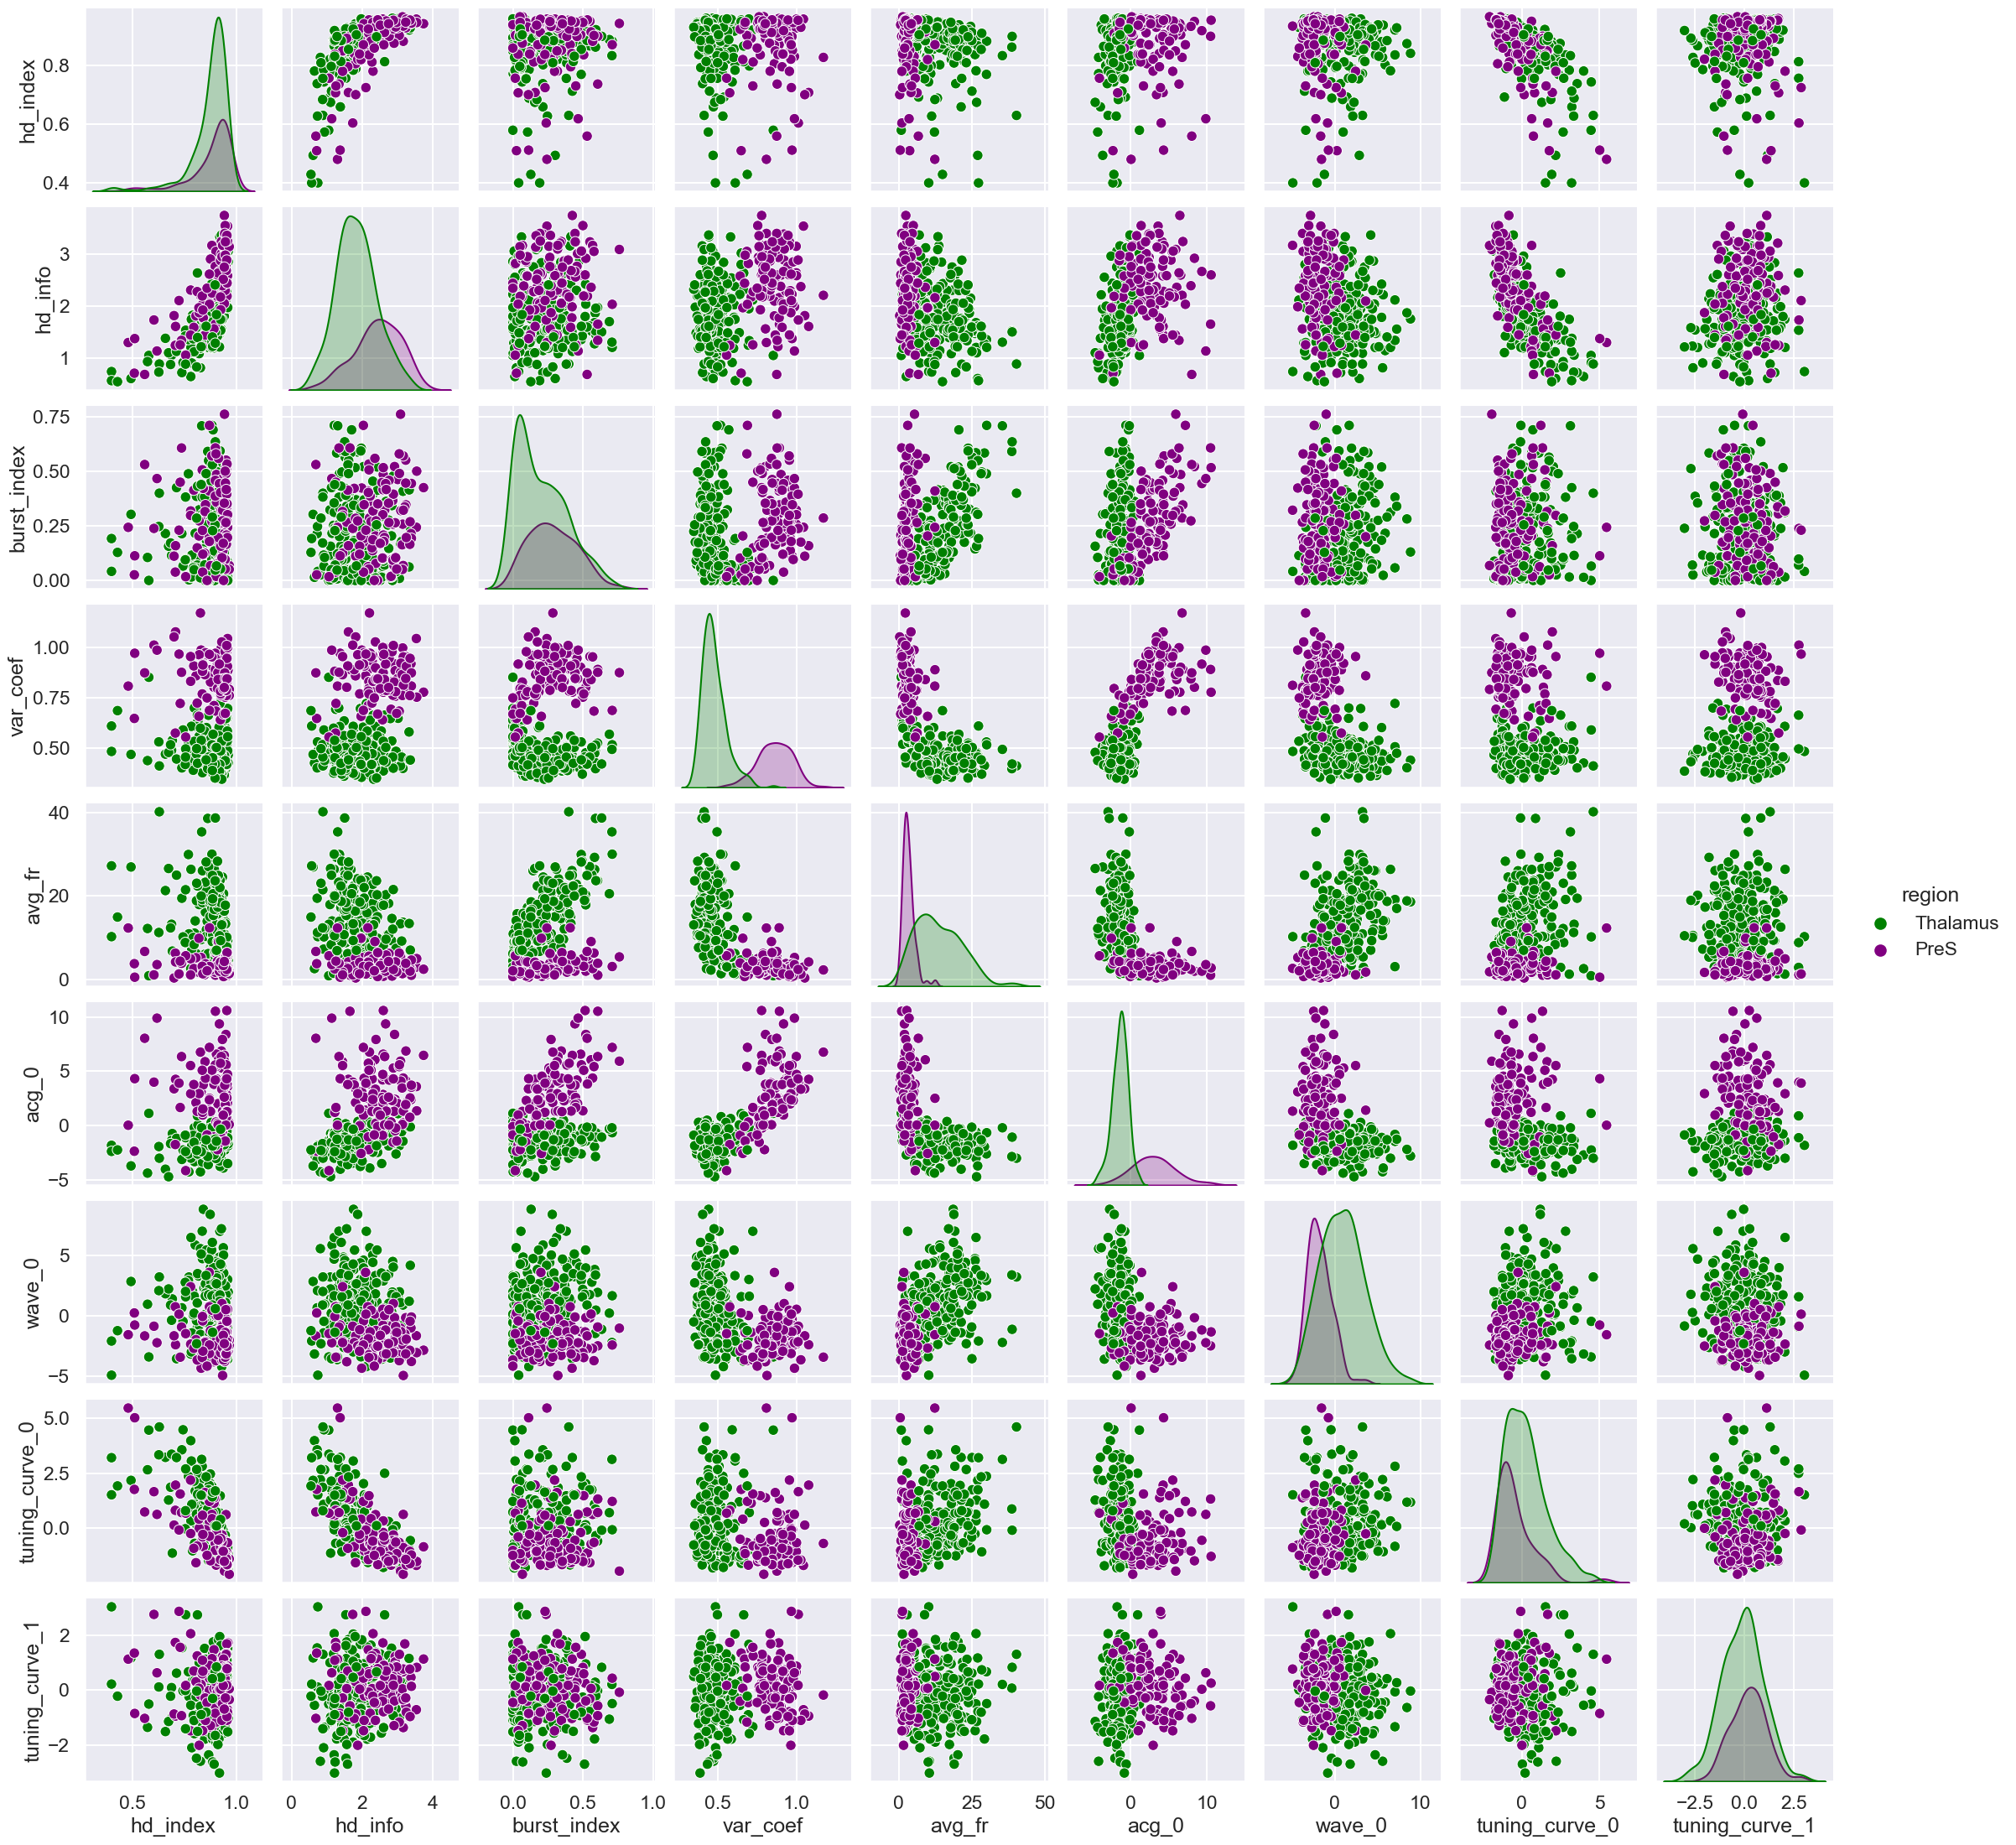

In [11]:
sns.set_theme('talk')
plt.figure(figsize=(8,8))
sns.pairplot(data=hdcells, hue='region', vars=hdfeature_li_all,palette=['green', 'purple'])
plt.savefig('plots/tsne2_features.pdf',format='pdf')

In [518]:
scaler = StandardScaler()
scaler.fit(hdcells[hdfeature_li_all])
x = scaler.transform(hdcells[hdfeature_li_all])
perplexity=12

tsne = TSNE(
    perplexity=perplexity,
    metric="euclidean",
    n_jobs=8,
    random_state=10,
    verbose=False,
)

embedding_hdcells = tsne.fit(x) 

clusterer = hdbscan.HDBSCAN(algorithm='best',alpha=1.5, leaf_size=12,
    metric='euclidean', min_cluster_size=15,  min_samples=8, p=None)
clusterer.fit(embedding_hdcells)
hdcells.loc[:,'tsne_x'] = np.array(-embedding_hdcells)[:,0]
hdcells.loc[:,'tsne_y'] = np.array(embedding_hdcells)[:,1]

hdcells.loc[:,'hdscan_label'] = clusterer.labels_


In [519]:
hdcells.hdscan_label = hdcells.hdscan_label.astype('str')
hdcells.loc[hdcells.hdscan_label=='0','hdscan_label']='PreS cluster'
hdcells.loc[hdcells.hdscan_label=='2','hdscan_label']='ATN cluster1'
hdcells.loc[hdcells.hdscan_label=='1','hdscan_label']='ATN cluster2'
hdcells.loc[hdcells.hdscan_label=='-1','hdscan_label']='Unclustered'

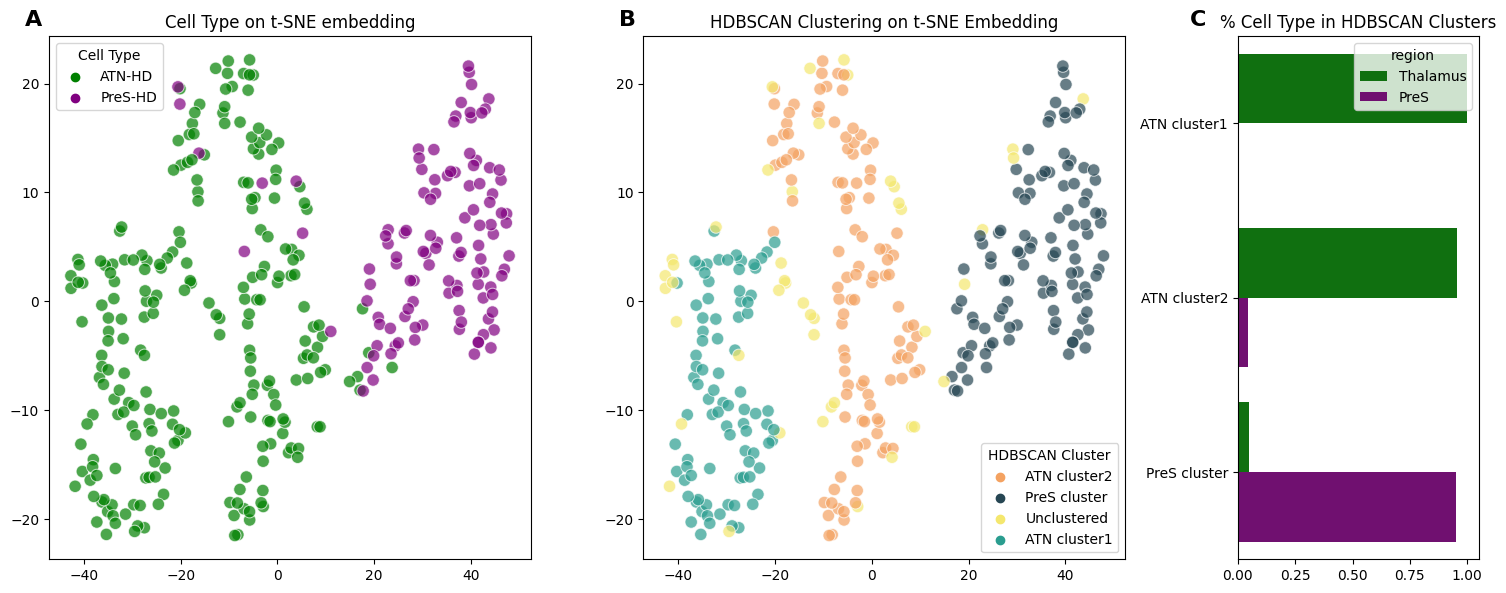

In [520]:
# from sklearn.cluster import KMeans

# kmeans = KMeans(random_state=0, n_init="auto").fit(embedding)
# sns.scatterplot(x=np.array(embedding)[:,0], y=np.array(embedding)[:,1],hue=kmeans.labels_,s=80,alpha=.7,palette='tab10')


fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,6),gridspec_kw={'width_ratios':[2,2,1]})
g = sns.scatterplot(ax=axes[0], data=hdcells,x='tsne_x', y='tsne_y',hue='region',s=80,alpha=.7,palette=['green','purple'])
axes[0].set_title('Cell Type on t-SNE embedding')
axes[0].set_ylabel('')
axes[0].set_xlabel('')
new_labels = ['ATN-HD','PreS-HD']
legend = g.legend(title='Cell Type')
for i,l in enumerate(new_labels):
    legend.texts[i].set_text(l)


g=sns.scatterplot(ax=axes[1], data=hdcells,x='tsne_x', y='tsne_y',hue='hdscan_label',s=80,alpha=.7,palette=palette)
axes[1].set_title('HDBSCAN Clustering on t-SNE Embedding')
legend = g.legend(title='HDBSCAN Cluster')
# new_labels = ['Unclustered', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4']
# legend = g.legend(title='HDSCAN Cluster')
# for i,l in enumerate(new_labels):
#     legend.texts[i].set_text(l)
axes[1].set_ylabel('')
axes[1].set_xlabel('')    
counts = hdcells.loc[hdcells.hdscan_label!='Unclustered'].groupby(['hdscan_label', 'region']).size().reset_index(name='counts')
totals = hdcells.groupby('hdscan_label').size().reset_index(name='hdscan_label_total')
merged = pd.merge(counts, totals, on='hdscan_label')

# Calculate proportions
merged['proportion'] = merged['counts'] / merged['hdscan_label_total']
merged[['hdscan_label','region']] = merged[['hdscan_label','region']].astype('str')
g=sns.barplot(ax=axes[2],data=merged,x='proportion',y='hdscan_label',hue="region",palette=['green','purple'])

g.set_yticks(np.arange(0,3),['ATN cluster1','ATN cluster2','PreS cluster'])
axes[2].set_ylabel('')
axes[2].set_xlabel('')

# new_labels = ['ATN-HD','PreS-HD']
# legend = g.legend(title='Cell Type')
# for i,l in enumerate(new_labels):
#     legend.texts[i].set_text(l)
# g.xaxis.tick_top()
# g.xaxis.set_label_position('top') 
axes[2].set_title('% Cell Type in HDBSCAN Clusters')
for i, ax in enumerate(axes[:2]):
    ax.text(-.05, 1.05, chr(65 + i), transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')
axes[2].text(-.2, 1.05, chr(65 + 2), transform=axes[2].transAxes,
        fontsize=16, fontweight='bold', va='top')
plt.tight_layout()
    
plt.savefig('./plots/figure-result2.pdf',format='pdf')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PreS cluster vs. ATN cluster1: Welch's t-test independent samples, P_val:4.794e-03 t=-2.855e+00
ATN cluster2 vs. PreS cluster: Welch's t-test independent samples, P_val:9.569e-18 t=-9.599e+00
ATN cluster2 vs. ATN cluster1: Welch's t-test independent samples, P_val:6.235e-27 t=-1.326e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PreS cluster vs. ATN cluster1: Welch's t-test independent samples, P_val:2.036e-74 t=3.523e+01
ATN cluster2 vs. PreS cluster: Welch's t-test independent samples, P_val:4.352e-68 t=-2.674e+01
ATN cluster2 vs. ATN cluster1: Welch's t-test independent samples, P_val:4.055e-07 t=5.265e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.0

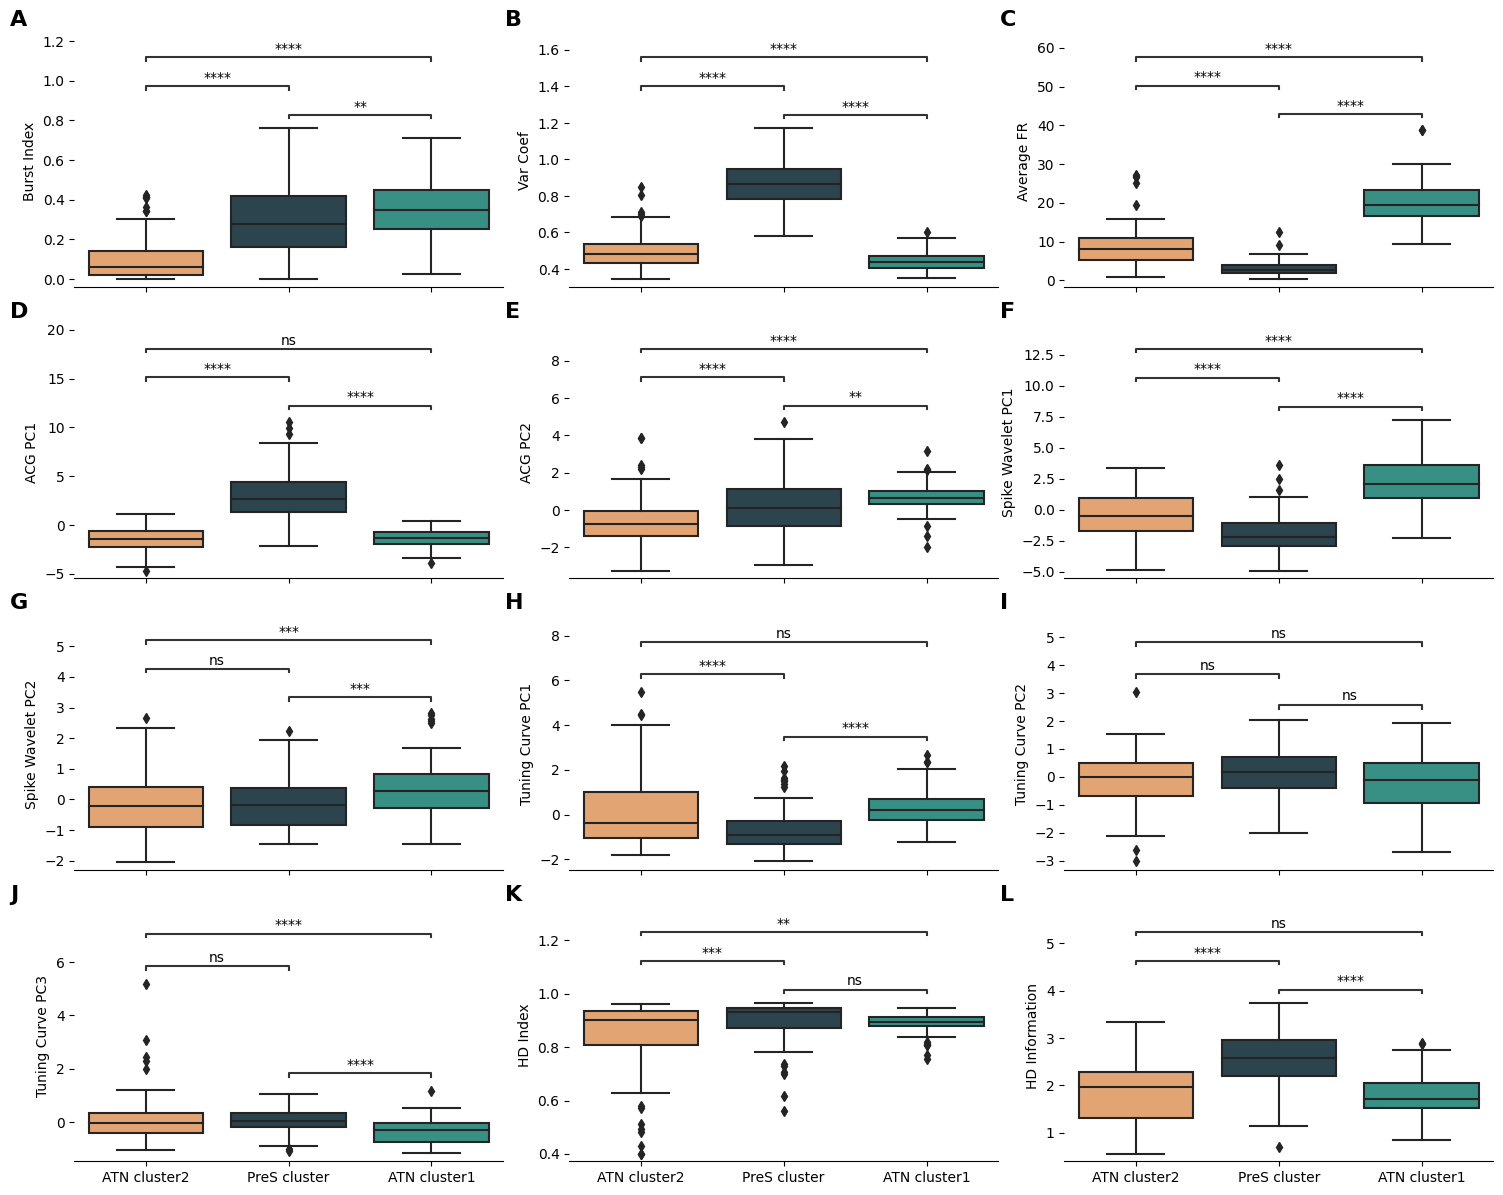

In [521]:

plot_feature_li_hd = ['burst_index','var_coef','avg_fr','acg_0','acg_1','wave_0','wave_1','tuning_curve_0','tuning_curve_1','tuning_curve_2','hd_index','hd_info']
plot_feature_name_hd = ['Burst Index','Var Coef','Average FR','ACG PC1','ACG PC2',
                         'Spike Wavelet PC1','Spike Wavelet PC2','Tuning Curve PC1','Tuning Curve PC2','Tuning Curve PC3',
                         'HD Index','HD Information']
fig,axes = plt.subplots(ncols=3,nrows=4,figsize=(15,12),sharex=True)
for r in range(4):
    for c in range(3):
        f_id = r*3+c
        sns.boxplot(ax=axes[r,c],data=hdcells.loc[hdcells.hdscan_label!="Unclustered"],
               x='hdscan_label',y=plot_feature_li_hd[f_id],palette=palette)
        axes[r,c].spines['top'].set_visible(False)
        axes[r,c].spines['right'].set_visible(False)
        axes[r,c].spines['left'].set_visible(False)
        axes[r,c].set_xlabel('')
        axes[r,c].set_ylabel(plot_feature_name_hd[f_id])
        pairs=[("ATN cluster1", "ATN cluster2"), ("ATN cluster1", "PreS cluster"), ("ATN cluster2", "PreS cluster")]

        annotator = Annotator(axes[r,c], pairs, data=hdcells.loc[hdcells.hdscan_label!="Unclustered"], x='hdscan_label', y=plot_feature_li_hd[f_id])
        annotator.configure(test='t-test_welch', text_format='star', loc='inside')
        annotator.apply_and_annotate()
for i, ax in enumerate(axes.flatten()):
    ax.text(-.15, 1.1, chr(65 + i), transform=ax.transAxes,
        fontsize=16, fontweight='bold', va='top')   

plt.tight_layout()
plt.savefig('./result2-1.svg',format='svg')

In [522]:
temp_df.loc[:,'allcells_label'] = allcells.loc[hdcells.index,'hdscan_label']
temp_df.loc[:,'hdcells_label'] = hdcells.hdscan_label
temp_df_merge = temp_df.dropna()

In [523]:
temp_df_merge = temp_df_merge.loc[(temp_df_merge.allcells_label!='Unclustered')&(temp_df_merge.hdcells_label!='Unclustered')]

<Figure size 600x500 with 0 Axes>

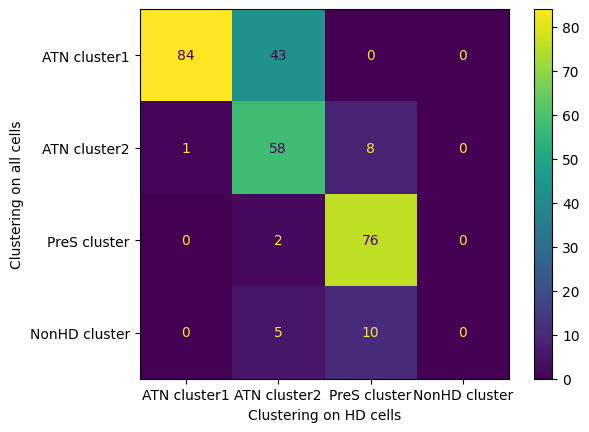

In [569]:

plt.figure(figsize=(6,5))

cm = confusion_matrix(temp_df_merge.allcells_label.values, temp_df_merge.hdcells_label.values,labels=['ATN cluster1','ATN cluster2','PreS cluster','NonHD cluster'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['ATN cluster1','ATN cluster2','PreS cluster','NonHD cluster'])
disp.plot()
plt.xlabel('Clustering on HD cells')
plt.ylabel('Clustering on all cells')

plt.savefig('./confusion-matrix.pdf',format='pdf')

In [554]:
regr = LinearRegression()
regr.fit(hdcells[["tsne_x","tsne_y"]], hdcells["hd_info"])
y_pred_hd_info = regr.predict(hdcells[["tsne_x","tsne_y"]])
r2_hd_info = r2_score(hdcells["hd_info"], y_pred_hd_info)

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(hdcells[["tsne_x",'tsne_y']])

# Create and fit the model
regr = LinearRegression()
regr.fit(X_poly, hdcells["burst_index"])

# Make predictions
y_pred_burst_index = regr.predict(X_poly)

# Calculate R^2
r2_burst_index = r2_score(hdcells["burst_index"], y_pred_burst_index)


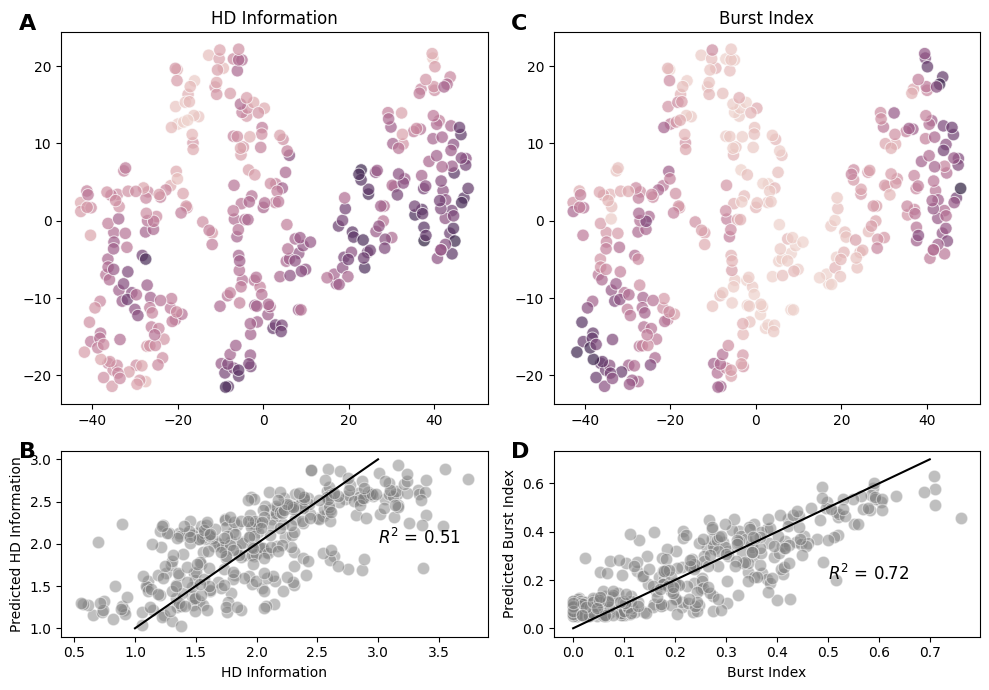

In [555]:

fig,axes=plt.subplots(ncols=2,nrows=2,figsize=(10,7),gridspec_kw={'height_ratios':[4,2]})
g = sns.scatterplot(ax=axes[0,0],data=hdcells,x='tsne_x', y='tsne_y',
                hue='hd_info',s=80,alpha=.7,legend=False)
axes[0,0].set_title('HD Information')
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('')
# new_labels = ['ATN-HD','PreS-HD']
# legend = g.legend(title='Cell Type')
# for i,l in enumerate(new_labels):
#     legend.texts[i].set_text(l)

g=sns.scatterplot(ax=axes[0,1],data=hdcells,x='tsne_x', y='tsne_y',
                hue='burst_index',s=80,alpha=.7,legend=False)
axes[0,1].set_title('Burst Index')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')
sns.scatterplot(ax=axes[1,0],y=y_pred_hd_info,x=hdcells["hd_info"],color='grey',s=80,alpha=.5)
sns.lineplot(ax=axes[1,0],x=np.linspace(1,3,100),y=np.linspace(1,3,100),color='black')
axes[1,0].text(3,2,f'$R^2$ = {r2_hd_info:.2f}', fontsize=12)
axes[1,0].set_xlabel("HD Information")
axes[1,0].set_ylabel("Predicted HD Information")
sns.scatterplot(ax=axes[1,1],y=y_pred_burst_index,x=hdcells["burst_index"],color='grey',s=80,alpha=.5)
sns.lineplot(ax=axes[1,1],x=np.linspace(0,.7,100),y=np.linspace(0,.7,100),color='black')
axes[1,1].text(0.5,0.2,f'$R^2$ = {r2_burst_index:.2f}', fontsize=12)
axes[1,1].set_xlabel("Burst Index")
axes[1,1].set_ylabel("Predicted Burst Index")

for i, ax in enumerate(axes.swapaxes(0,1).flatten()):
    ax.text(-.1, 1.05, chr(65 + i), transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('./plots/figure-result2-intepration.pdf',format='pdf')


In [528]:

scaler = StandardScaler()
scaler.fit(hdcells.loc[hdcells.hdscan_label!='Unclustered'][hdfeature_li_all])
indices = hdcells.loc[hdcells.hdscan_label!='Unclustered'].index
x = scaler.transform(hdcells.loc[hdcells.hdscan_label!='Unclustered'][hdfeature_li_all])
y = hdcells.loc[hdcells.hdscan_label!='Unclustered'].hdscan_label
# label = hdcells.loc[hdcells.hdscan_label>-1].true_label
N_repeat = 100
perplexity=12
acchd = np.zeros(N_repeat)
predict_hdlabel = np.zeros((N_repeat,int(np.ceil(len(x)/10)))).astype('str')
y_hdlabel = np.zeros((N_repeat,int(np.ceil(len(x)/10)))).astype('str')

for k in range(N_repeat):
    x_train, x_test, y_train, y_test, train_indice, test_indice = train_test_split(x, y, indices, test_size=.1)
    
    tsne = TSNE(
        perplexity=perplexity,
        metric="euclidean",
        n_jobs=8,
        random_state=42,
        verbose=False,
    )
    embedding_train = tsne.fit(x_train) 
    embedding_test = embedding_train.transform(x_test)

    
    for i in range(len(np.array(embedding_test))):
        min_index = find_nearest_point_numpy(np.array(embedding_train), np.array(embedding_test)[i,0], np.array(embedding_test)[i,0])
        predict_hdlabel[k,i]=y_train.values[min_index]
        if (y_train.values[min_index]==y_test.values[i]):
            acchd[k] = acchd[k]+1
    # print(acc/len(np.array(embedding_test)))
    y_hdlabel[k,:] = y_test.values
    acchd[k]=acchd[k]/len(np.array(embedding_test))
#     print('=========%03d========='%k)

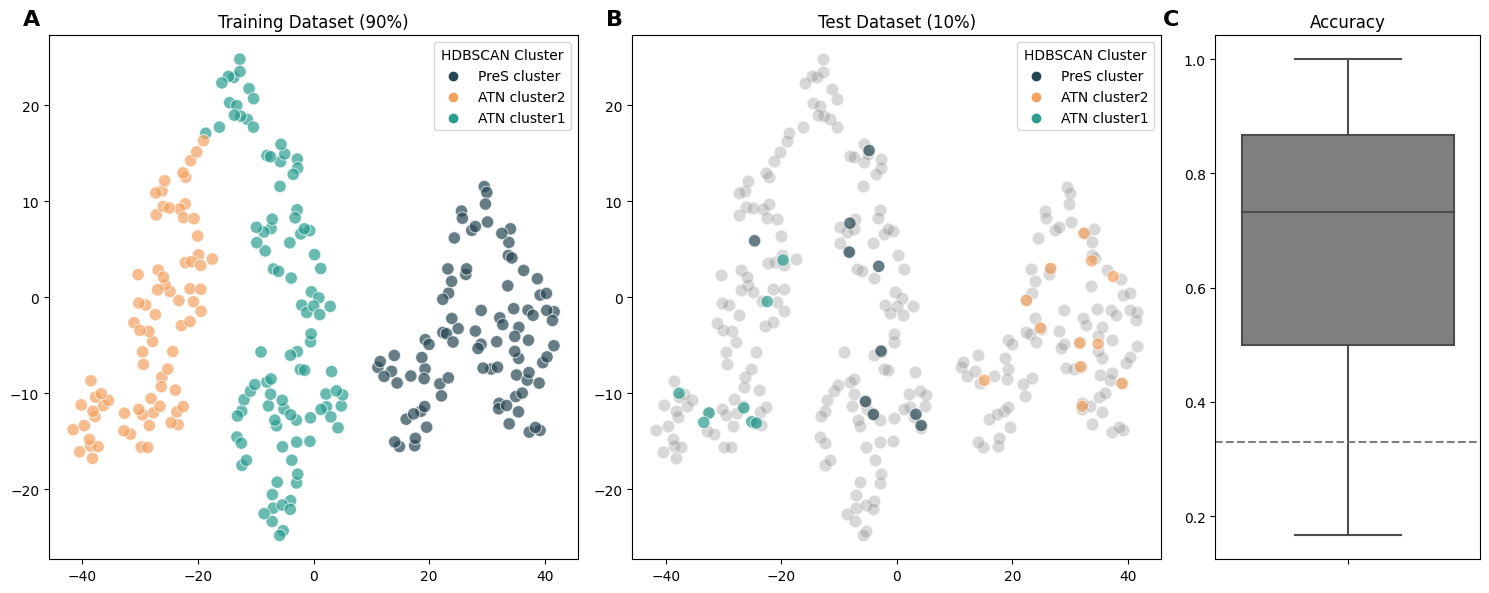

In [529]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,6),gridspec_kw={'width_ratios':[2,2,1]})

g=sns.scatterplot(ax=axes[0],x=np.array(-embedding_train)[:,0], y=np.array(embedding_train)[:,1],hue=y_train,s=80,alpha=.7,palette=palatte)
axes[0].set_title('Training Dataset (90%)')

new_labels = ['PreS cluster','ATN cluster2','ATN cluster1']
legend = g.legend(title='HDBSCAN Cluster')
for i,l in enumerate(new_labels):
    legend.texts[i].set_text(l)

sns.scatterplot(ax=axes[1],x=np.array(-embedding_train)[:,0], y=np.array(embedding_train)[:,1],s=80,alpha=.3,c='gray')
g=sns.scatterplot(ax=axes[1],x=np.array(-embedding_test)[:,0], y=np.array(embedding_test)[:,1],hue=y_test,s=80,alpha=.7,palette=palatte)

axes[1].set_title('Test Dataset (10%)')

new_labels = ['PreS cluster','ATN cluster2','ATN cluster1']
legend = g.legend(title='HDBSCAN Cluster')
for i,l in enumerate(new_labels):
    legend.texts[i].set_text(l)

sns.boxplot(ax=axes[2],y=acchd,color='grey',saturation=.5)
axes[2].axhline(y=.33,color='grey',linestyle='--')
axes[2].set_title('Accuracy')
plt.tight_layout()
for i, ax in enumerate(axes[:2]):
    ax.text(-.05, 1.05, chr(65 + i), transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')
axes[2].text(-.2, 1.05, chr(65 + 2), transform=axes[2].transAxes,
        fontsize=16, fontweight='bold', va='top')
plt.savefig('./plots/figure-result2validation.pdf',format='pdf')


In [557]:
np.std(acchd)

0.2225356400918988

[0.26683605 0.14264709 0.08846391 0.05241052 0.02221019 0.01508626
 0.01343535 0.01279274 0.01192931 0.01125023]
[0.71417519 0.1428119  0.05605038 0.03210451 0.02293296 0.01419139
 0.00716324 0.00357007 0.00254732 0.00152179]


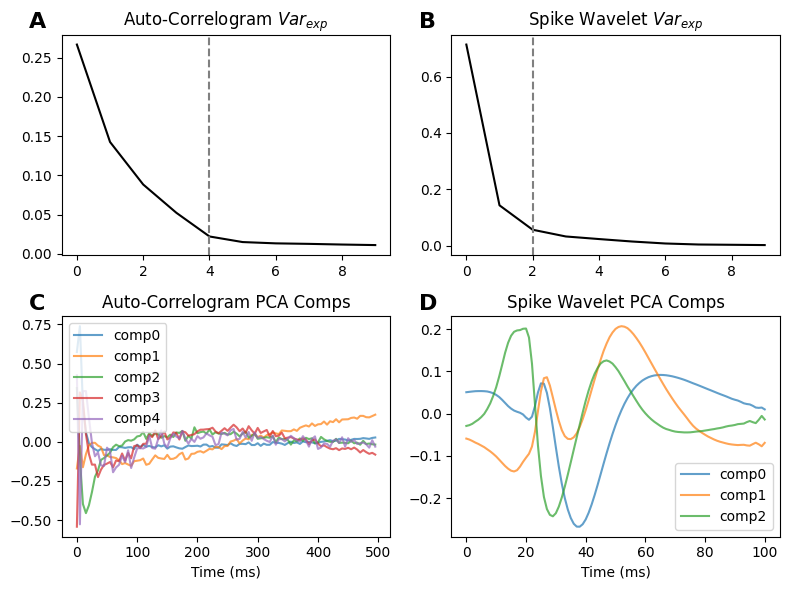

In [530]:
from sklearn.decomposition import PCA
curve_data = {}
comp_selected = [4,2]
xaxis = [np.arange(0,500,5),np.arange(0,101)]
data_label = ['Auto-Correlogram','Spike Wavelet']
# hd_index = np.where((results.p_hd_index<.05)&(results.hd_index>.4))[0]
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(8,6))
for i, data_type in enumerate(['acg','wave']):
    curve_data[data_type] = pd.read_csv('../analysis/step1/'+data_type+'.csv',header=None)
    curve_data[data_type].index=range(1,654)
    pca = PCA(n_components=10)
    scaler = StandardScaler()
    x_standardized =scaler.fit_transform(curve_data[data_type].iloc[allcells.index-1,:].values.T)
    pca.fit(x_standardized.T)
    print(pca.explained_variance_ratio_)
    axes[0,i].plot(pca.explained_variance_ratio_,color='black')
    axes[0,i].axvline(x=comp_selected[i],color='grey',linestyle='--')
    axes[0,i].set_title(data_label[i]+' $Var_{exp}$')
    for k in range(comp_selected[i]+1):
        axes[1,i].plot(xaxis[i],pca.components_[k,:].T,label='comp%d'%k,alpha=.7)
    axes[1,i].set_title(data_label[i]+' PCA Comps')
    axes[1,i].set_xlabel('Time (ms)')
    axes[1,i].legend()
for i, ax in enumerate(axes.flatten()):
    ax.text(-.1, 1.1, chr(65 + i), transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')

plt.tight_layout()

plt.savefig('./plots/sup_pca1.pdf',format='pdf')


In [ ]:
curve_data = {}
comp_selected = [1,2,1]
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(15,10))
xaxis = [np.arange(0,500,5),np.arange(0,370,10),np.arange(0,101)]
xlabel = ['Time (ms)','Direction ($\circ$)','Time (ms)']
data_label = ['Auto-Correlogram','Tuning Curve','Spike Wavelet']

for i, data_type in enumerate(['acg','tuning_curve','wave']):
    curve_data[data_type] = pd.read_csv('../analysis/step1/'+data_type+'.csv',header=None)
    curve_data[data_type].index=range(1,654)
    pca = PCA(n_components=5)
    scaler = StandardScaler()
    x_standardized =scaler.fit_transform(curve_data[data_type].iloc[hdcells.index.values-1,:].values.T)
    pca.fit(x_standardized.T)
    print(pca.explained_variance_ratio_)
    axes[0,i].plot(pca.explained_variance_ratio_,color='black')
    axes[0,i].axvline(x=comp_selected[i],color='grey',linestyle='--')
    axes[0,i].set_title(data_label[i]+' $Var_{exp}$')
    for k in range(comp_selected[i]+1):
        axes[1,i].plot(xaxis[i],pca.components_[k,:].T,label='comp%d'%k)

    axes[1,i].set_title(data_label[i]+' PCA Comps')
    axes[1,i].set_xlabel(xlabel[i])
    axes[1,i].legend()
for i, ax in enumerate(axes.flatten()):
    ax.text(-.1, 1.1, chr(65 + i), transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')
plt.savefig('./plots/sup_pca2.pdf',format='pdf')


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_label.flatten(), predict_label.flatten())

In [ ]:
cm = confusion_matrix(y_label.flatten(), predict_label.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_hdlabel.flatten(), predict_hdlabel.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()